In [ ]:
import pandas as pd
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import word_tokenize
from nltk.stem.porter import *
nltk.download('punkt')
nltk.download('stopwords')
!pip install git+https://github.com/LIAAD/yake
import yake
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-43yf3mh4
  Running command git clone --filter=blob:none --quiet https://github.com/LIAAD/yake /tmp/pip-req-build-43yf3mh4
  Resolved https://github.com/LIAAD/yake to commit 374fc1c1c19eb080d5b6115cbb8d4a4324392e54
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.4 MB/s eta 0:00:00
  Created wheel for yake: filename=yake-0.4.8-py2.py3-none-any.whl size=62570 sha256=c7246951de88b50b3e38892210af2a29082e999ad0c558a266409ee52928dc55
  Stored in directory: /tmp/pip-ephem-wheel-cache-ewcbaajy/wheels/10/9d/33/6a3358fd876c3d7c6c5c139d1496eb4b1618c7d0e15c375584
Successfully built yake


In [ ]:
df_train = pd.read_csv('news-train-1.csv')
df_train

,ArticleId,Text,Category
0,893,rangers seal old firm win goals from gregory v...,sport
1,1164,bt program to beat dialler scams bt is introdu...,tech
2,1696,new yob targets to be unveiled fifty new are...,politics
3,396,holmes is hit by hamstring injury kelly holmes...,sport
4,1862,capriati out of australian open jennifer capri...,sport
...,...,...,...
1058,101,housewives lift channel 4 ratings the debut of...,entertainment
1059,1369,no uk apology for colonial past the days of b...,politics
1060,2221,cars pull down us retail figures us retail sal...,business
1061,916,highbury tunnel players in clear the football ...,sport


In [ ]:
df_test = pd.read_csv('news-test.csv')
df_test

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


<h2>Question 1</h2>

In [ ]:
# PRE-PROCESS DATA

# stemming tool from nltk
stemmer = PorterStemmer()
# a mapping dictionary that help remove punctuations
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)
def get_tokens(text):
  # turn document into lowercase
  lowers = text.lower()
  # remove punctuations
  no_punctuation = lowers.translate(remove_punctuation_map)
  # tokenize document
  tokens = nltk.word_tokenize(no_punctuation)
  # remove stop words
  filtered = [w for w in tokens if not w in stopwords.words('english')]
  # stemming process
  stemmed = []
  for item in filtered:
      stemmed.append(stemmer.stem(item))
  # final unigrams
  return stemmed

In [ ]:
tokens = []
for i in range(len(df_train['Text'])):
  tokens.append(get_tokens(df_train['Text'][i]))
flatten_tokens = [' '.join(i) for i in tokens]
# flatten_tokens

In [ ]:
# N-GRAMS

n_grams = ngrams(sequence=word_tokenize(flatten_tokens[0]), n = 2)
for i in n_grams:
  print(i)

('ranger', 'seal')
('seal', 'old')
('old', 'firm')
('firm', 'win')
('win', 'goal')
('goal', 'gregori')
('gregori', 'vignal')
('vignal', 'nacho')
('nacho', 'novo')
('novo', 'gave')
('gave', 'ranger')
('ranger', 'scrappi')
('scrappi', 'victori')
('victori', 'celtic')
('celtic', 'park')
('park', 'move')
('move', 'three')
('three', 'point')
('point', 'clear')
('clear', 'champion')
('champion', 'ranger')
('ranger', 'rare')
('rare', 'threaten')
('threaten', 'celtic')
('celtic', 'goalkeep')
('goalkeep', 'rab')
('rab', 'dougla')
('dougla', 'let')
('let', 'defend')
('defend', 'vignal')
('vignal', '25yard')
('25yard', 'drive')
('drive', 'slip')
('slip', 'grasp')
('grasp', 'net')
('net', 'opposit')
('opposit', 'number')
('number', 'ronald')
('ronald', 'waterreu')
('waterreu', 'ranger')
('ranger', 'hero')
('hero', 'save')
('save', 'superbl')
('superbl', 'craig')
('craig', 'bellami')
('bellami', 'john')
('john', 'hartson')
('hartson', 'striker')
('striker', 'novo')
('novo', 'secur')
('secur', 'vict

In [ ]:
txt = df_train['Category'][0] + ", "+ df_train['Text'][0]

In [ ]:
# KEYWORD EXTRACTION (USING YAKE)

kw_extractor = yake.KeywordExtractor(top=10, stopwords=None)
keywords = kw_extractor.extract_keywords(txt)
for kw, v in keywords:
  print("Keyphrase: ",kw, ": score", v)

Keyphrase:  rangers : score 0.04630980175585075
Keyphrase:  celtic : score 0.04697226914571401
Keyphrase:  park that moves : score 0.04846672733671171
Keyphrase:  hartson : score 0.06371604782532204
Keyphrase:  nacho novo gave : score 0.07032816522445062
Keyphrase:  waterreus : score 0.07445854762640175
Keyphrase:  firm win goals : score 0.08035997155202936
Keyphrase:  douglas : score 0.08294525046317637
Keyphrase:  drive : score 0.08685768865180106
Keyphrase:  celtic park : score 0.08789474882810663


In [ ]:
# KEYWORD EXTRACTION (USING SUMMA)

!pip install summa
from summa import keywords

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54389 sha256=36562e7480ac3654b0c3d05d6bde4a44bb93fb2dfb91150a162cdcfbcc2de6b4
  Stored in directory: /root/.cache/pip/wheels/4a/ca/c5/4958614cfba88ed6ceb7cb5a849f9f89f9ac49971616bc919f
Successfully built summa


In [ ]:
TR_keywords = keywords.keywords(txt, scores=True)
print(TR_keywords[0:10])

[('rangers', 0.26737349255783566), ('celtic', 0.23261987302725476), ('douglas', 0.22220545609034706), ('novo', 0.19925757360521487), ('hartson', 0.19291065288312417), ('bellamy', 0.17017830896613115), ('ricksen', 0.17004060507756663), ('waterreus', 0.16463647963285644), ('vignal', 0.16047590176290066), ('firm', 0.1319125107852816)]


In [ ]:
# COUNT VECTORIZER

X = flatten_tokens
y = df_train['Category']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
vectorizer = CountVectorizer(max_features=10000)
X = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_score = []
val_l = []
val_a = []
TL = []
TA = []
for i, j in kf.split(X, y):
    X_train_fold, X_val_fold = X[i], X[j]
    y_train_fold, y_val_fold = y[i], y[j]
    model = create_model()
    temp = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)
    vl, va = model.evaluate(X_val_fold, y_val_fold)
    # acc_score.append(temp_acc)
    val_l.append(vl)
    val_a.append(va)
    TL.append(temp.history['loss'])
    TA.append(temp.history['accuracy'])


models_to_accuracies = {
    'CountVectorizer' :
    {
        'Average Training Accuracy': np.mean(TA),
        'Average Validation Accuracy': np.mean(val_a),
        'Average Training Loss': np.mean(TL),
        'Average Validation Loss': np.mean(val_l)
    }
}

7/7 [==============================] - 0s 7ms/step - loss: 0.0712 - accuracy: 0.9670


In [ ]:
# TFIDF VECTORIZER

X = flatten_tokens
y = df_train['Category']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_score = []
acc_score = []
val_l = []
val_a = []
TL = []
TA = []
for i, j in kf.split(X, y):
    X_train_fold, X_val_fold = X[i], X[j]
    y_train_fold, y_val_fold = y[i], y[j]
    model = create_model()
    temp = model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)
    vl, va = model.evaluate(X_val_fold, y_val_fold)
    val_l.append(vl)
    val_a.append(va)
    TL.append(temp.history['loss'])
    TA.append(temp.history['accuracy'])

models_to_accuracies['TFIDF VECTORIZER'] = {
        'Average Training Accuracy': np.mean(TA),
        'Average Validation Accuracy': np.mean(val_a),
        'Average Training Loss': np.mean(TL),
        'Average Validation Loss': np.mean(val_l)
}

7/7 [==============================] - 0s 5ms/step - loss: 0.0960 - accuracy: 0.9764


In [ ]:
# GloVe with gensim


glove_input_file = 'glove.6B.50d.txt'
glove2word2vec(glove_input_file, 'out.txt')
glove_model = KeyedVectors.load_word2vec_format('out.txt', binary=False)

word_vectors = []
for text in flatten_tokens:
    tokens = text.split()
    vectors = [glove_model[word] if word in glove_model else np.zeros(glove_model.vector_size) for word in tokens]
    mean_vector = np.mean(vectors, axis=0)
    word_vectors.append(mean_vector)

X_glove = np.array(word_vectors)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train['Category'])
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_glove.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

n = 5
train_loss = []
train_acc = []
val_l = []
val_a = []
kf = StratifiedKFold(n_splits=n, shuffle=True, random_state=42)
for i, j in kf.split(X_glove, y_encoded):
    X_train, X_val = X_glove[i], X_glove[j]
    y_train, y_val = y_encoded[i], y_encoded[j]
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=False)
    val_loss, val_accuracy = model.evaluate(X_val, y_val)
    val_l.append(val_loss)
    val_a.append(val_accuracy)
    train_loss.append(history.history['loss'])
    train_acc.append(history.history['accuracy'])

models_to_accuracies['GloVe with gensim'] = {
        'Average Training Accuracy': np.mean(train_acc),
        'Average Validation Accuracy': np.mean(val_a),
        'Average Training Loss': np.mean(train_loss),
        'Average Validation Loss': np.mean(val_l)
}

# for fold, (train_loss, val_loss, train_accuracy, val_accuracy) in enumerate(zip(train_loss, val_loss, train_acc, val_acc)):
#     print(f'Fold {fold + 1} - Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_accuracy[-1]:.4f}')
#     print(f'          Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

<ipython-input-15-66000387c536>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, 'out.txt')


7/7 [==============================] - 0s 3ms/step - loss: 0.0786 - accuracy: 0.9764


In [ ]:
# BERT

%pip install bert-tensorflow
%pip install transformers
from transformers import BertTokenizer, TFBertModel, BertModel
import torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.0 MB/s eta 0:00:00


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

def text_to_bert_embedding(doc_text):
  input_ids = tokenizer.encode(doc_text, add_special_tokens=True, return_tensors='tf', padding=True, truncation=True)
  outputs = model(input_ids)
  hidden_states = outputs.last_hidden_state
  mean_embedding = tf.reduce_mean(hidden_states, axis=1)
  mean_embedding = mean_embedding.numpy()
  return mean_embedding.flatten()
x_bert = [text_to_bert_embedding(i) for i in flatten_tokens]
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Category'])

# def text_to_bert_embedding(doc_text):

#   input_ids = tokenizer.encode(doc_text, add_special_tokens=True, return_tensors='tf', padding=True, truncation=True)
#   outputs = bert_model(input_ids)
#   hidden_states = outputs.last_hidden_state
#   mean_embedding = tf.reduce_mean(hidden_states, axis=1)
#   mean_embedding = mean_embedding.numpy()
#   return mean_embedding.flatten()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
print(np.array(x_bert).shape)
print(y_train.shape)

(1063, 768)
(1063,)


In [ ]:
def create_model():
    model = None
    model = Sequential()
    model.add(Dense(128, input_dim=ttt.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model


    # model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    # model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_score = []
train_loss = []
train_acc = []
val_l = []
val_a = []
ttt = np.array(x_bert)
for i, j in kf.split(ttt, y_train):
    X_train_fold, X_val_fold = ttt[i], ttt[j]
    y_train_fold, y_val_fold = y_train[i], y_train[j]
    model = create_model()
    temp = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
    val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
    val_l.append(val_loss)
    val_a.append(val_accuracy)
    train_loss.append(temp.history['loss'])
    train_acc.append(temp.history['accuracy'])


models_to_accuracies['BERT'] = {
        'Average Training Accuracy': np.mean(train_acc),
        'Average Validation Accuracy': np.mean(val_a),
        'Average Training Loss': np.mean(train_loss),
        'Average Validation Loss': np.mean(val_l)
}

7/7 [==============================] - 0s 3ms/step - loss: 0.1032 - accuracy: 0.9528


In [ ]:
results_table = pd.DataFrame(models_to_accuracies).T

In [ ]:
results_table

,Average Training Accuracy,Average Validation Accuracy,Average Training Loss,Average Validation Loss
CountVectorizer,0.964909,0.973647,0.142827,0.105520
TFIDF VECTORIZER,0.939605,0.979290,0.426305,0.096413
GloVe with gensim,0.967604,0.966153,0.117486,0.094165
BERT,0.945225,0.967074,0.216340,0.089836


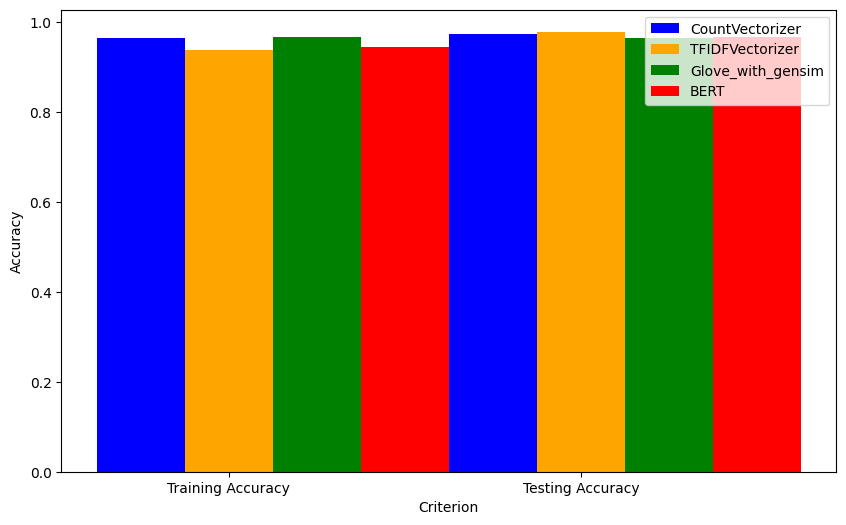

In [ ]:
import matplotlib.pyplot as plt
training_accuracies = list(results_table['Average Training Accuracy'])
validation_accuracies = list(results_table['Average Validation Accuracy'])
models = ['CountVectorizer', 'TFIDF VECTORIZER', 'GloVe with gensim', 'BERT']

data = pd.DataFrame({
    'model' : models,
    'training_accuracies':  training_accuracies,
    'validation_accuracies': validation_accuracies
})

cv_acc = list(data[data['model'] == 'CountVectorizer'].values[0][1:])
tf_acc = list(data[data['model'] == 'TFIDF VECTORIZER'].values[0][1:])
gl_acc = list(data[data['model'] == 'GloVe with gensim'].values[0][1:])
br_acc = list(data[data['model'] == 'BERT'].values[0][1:])

barWidth = 0.25
fig = plt.subplots(figsize=(10,6))

bar_1 = np.arange(len(gl_acc))
bar_2 = [x + barWidth for x in bar_1]
bar_3 = [x + barWidth for x in bar_2]
bar_4 = [x + barWidth for x in bar_3]

plt.bar(bar_1, cv_acc , color ='blue', width = barWidth,
        label ='CountVectorizer')
plt.bar(bar_2, tf_acc , color ='orange', width = barWidth,
        label ='TFIDFVectorizer')
plt.bar(bar_3, gl_acc , color ='green', width = barWidth,
        label ='Glove_with_gensim')
plt.bar(bar_4, br_acc , color ='red', width = barWidth,
        label ='BERT')


plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth for r in range(2)],
        ['Training Accuracy', 'Testing Accuracy'])

plt.legend()

In [ ]:
# COUNT VECTORIZER

X = flatten_tokens
y = df_train['Category']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X).toarray()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def create_model(l):
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=l), metrics=['accuracy'])
    return model

learning_rates =  [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]
best_lr = None
best_accuracy = 0

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_score = []
val_l = []
val_a = []
TL = []
TA = []
training_std = []
validation_std = []


for lr in learning_rates:
    training_losses_per = []
    training_accuracies_per = []
    validation_losses_per = []
    validation_accuracies_per = []
    for i, j in kf.split(X, y):
        X_train_fold, X_val_fold = X[i], X[j]
        y_train_fold, y_val_fold = y[i], y[j]
        model = create_model(lr)
        temp = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=32, verbose=0)
        vl, va = model.evaluate(X_val_fold, y_val_fold)
        validation_losses_per.append(vl)
        validation_accuracies_per.append(va)
        training_losses_per.append(temp.history['loss'])
        training_accuracies_per.append(temp.history['accuracy'])
    val_a.append(np.mean(validation_accuracies_per))
    val_l.append(np.mean(validation_losses_per))
    TA.append(np.mean(training_accuracies_per))
    TL.append(np.mean(training_losses_per))
    training_std.append(np.std(training_accuracies_per))
    validation_std.append(np.std(validation_accuracies_per))
    mean_accuracy = np.mean(validation_accuracies_per)
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_lr = lr



7/7 [==============================] - 0s 5ms/step - loss: 5.3015 - accuracy: 0.9245


In [ ]:
TA

[0.8714739435911179,
 0.9284390103816986,
 0.9631474101543427,
 0.9774452483654023,
 0.9832550752162933,
 0.9836781346797943,
 0.9675920069217682]

In [ ]:
val_a

[0.9632961273193359,
 0.9755248427391052,
 0.9783461809158325,
 0.9774116396903991,
 0.96047922372818,
 0.966126310825348,
 0.9472982525825501]

In [ ]:
results_df = {
    'Learning Rates': learning_rates,
    'Average Training Accuracies': TA,
    'Average Validation Accuracies': val_a,
    'Training Standard Deviation' : training_std,
    'Validation Standard Deviation' : validation_std,
}

results_df = pd.DataFrame(results_df)

In [ ]:

results_df

,Learning Rates,Average Training Accuracies,Average Validation Accuracies,Training Standard Deviation,Validation Standard Deviation
0,0.0001,0.871474,0.963296,0.197875,0.011328
1,0.0003,0.928439,0.975525,0.165601,0.007582
2,0.0010,0.963147,0.978346,0.107690,0.009722
3,0.0030,0.977445,0.977412,0.067585,0.006944
4,0.0100,0.983255,0.960479,0.048401,0.016198
5,0.0300,0.983678,0.966126,0.045730,0.010056
6,0.1000,0.967592,0.947298,0.068024,0.012511


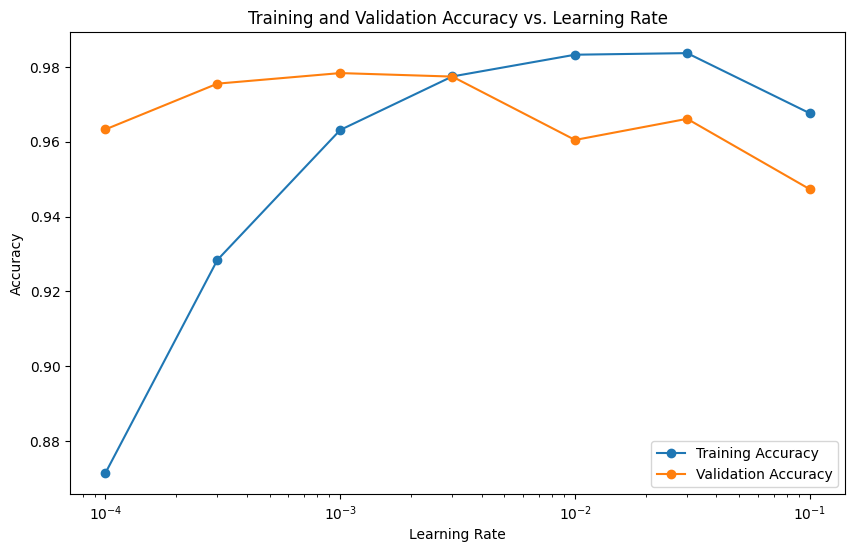

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, TA, marker='o', label='Training Accuracy')
plt.plot(learning_rates, val_a, marker='o', label='Validation Accuracy')

plt.title('Training and Validation Accuracy vs. Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
X = flatten_tokens
y = df_train['Category']
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(X).toarray()

optimizers = [ 'SGD',"RMSprop", 'Adam']

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train['Category'])

num_folds = 5

validation_losses = []
validation_accuracies = []
training_losses = []
training_accuracies = []
training_std = []
validation_std = []

best_optimizer = ''
best_accuracy = 0.0
best_loss = 100.0

kf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

for op in optimizers:
    training_losses_per = []
    training_accuracies_per = []
    validation_losses_per = []
    validation_accuracies_per = []

    model_6 = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(X.shape[1],)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')
            ])

    for train_indices, val_indices in kf.split(X, y):
        X_train, X_val = X[train_indices], X[val_indices]
        y_train, y_val = y_encoded[train_indices], y_encoded[val_indices]

        if op == 'SGD':
            optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        elif op == 'Adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
        elif op == 'RMSprop':
            optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)

        model_6.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        history = model_6.fit(X_train, y_train, epochs=10, batch_size=32, verbose=False)

        val_loss, val_accuracy = model_6.evaluate(X_val, y_val)
        validation_losses_per.append(val_loss)
        validation_accuracies_per.append(val_accuracy)

        training_losses_per.append(history.history['loss'])
        training_accuracies_per.append(history.history['accuracy'])
    validation_accuracies.append(np.mean(validation_accuracies_per))
    validation_losses.append(np.mean(validation_losses_per))
    training_accuracies.append(np.mean(training_accuracies_per))
    training_losses.append(np.mean(training_losses_per))
    training_std.append(np.std(training_accuracies_per))
    validation_std.append(np.std(validation_accuracies_per))



7/7 [==============================] - 0s 4ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
results_df = {
    'Optimizers': optimizers,
    'Average Training Accuracies': training_accuracies,
    'Average Validation Accuracies': validation_accuracies,
    'Training Standard Deviation' : training_std,
    'Validation Standard Deviation' : validation_std,
}

results_df = pd.DataFrame(results_df)

results_df

,Optimizers,Average Training Accuracies,Average Validation Accuracies,Training Standard Deviation,Validation Standard Deviation
0,SGD,0.430607,0.462977,0.082725,0.065877
1,RMSprop,0.994753,0.994366,0.034266,0.009104
2,Adam,0.996565,0.994366,0.021556,0.009104


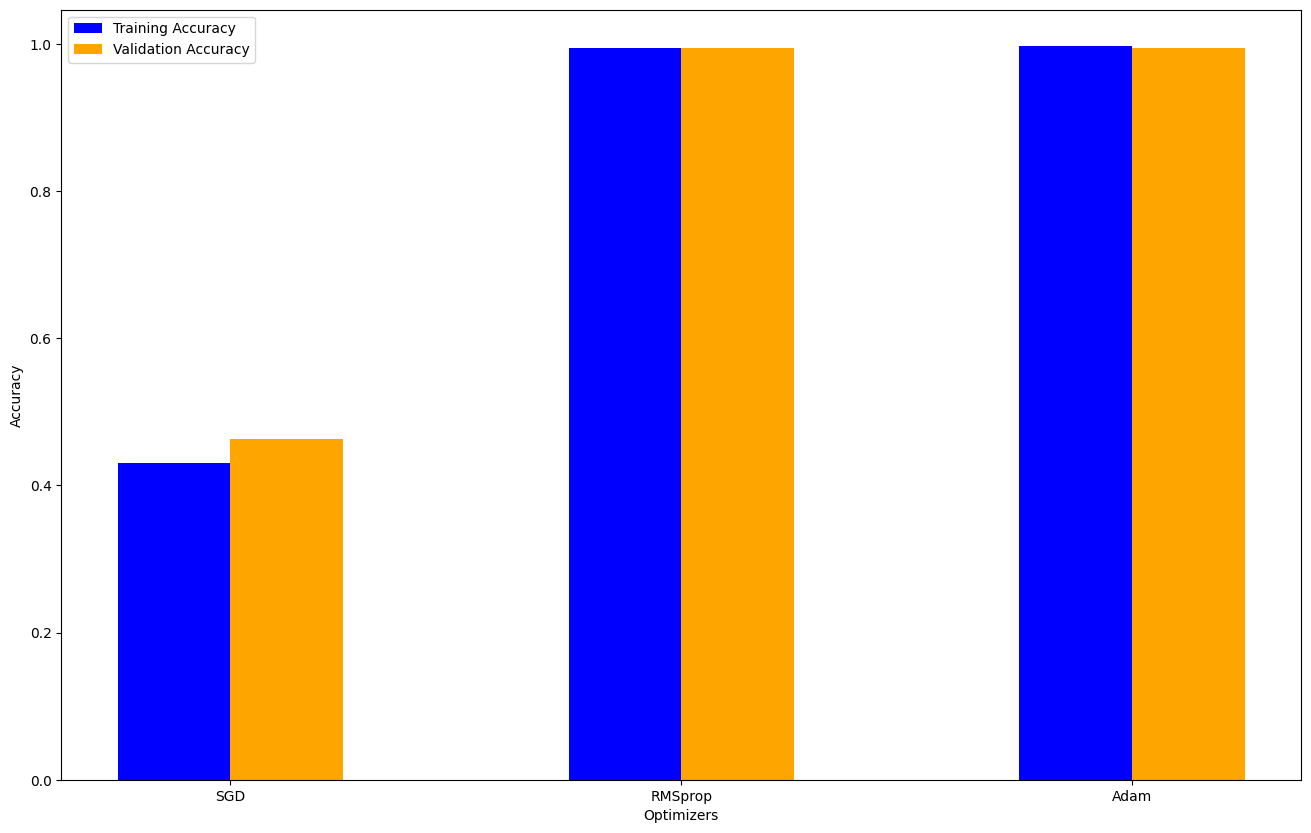

In [ ]:
import matplotlib.pyplot as plt

barWidth = 0.25
fig = plt.subplots(figsize=(16,10))

bar_1 = np.arange(3)
bar_2 = [x + barWidth for x in bar_1]
bar_3 = [x + barWidth for x in bar_2]

plt.bar(bar_1, training_accuracies , color ='blue', width = barWidth,
        label ='Training Accuracy')
plt.bar(bar_2, validation_accuracies , color ='orange', width = barWidth,
        label ='Validation Accuracy')

plt.xlabel('Optimizers')
plt.ylabel('Accuracy')
plt.xticks([r + barWidth/2 for r in range(3)],
        optimizers)

plt.legend()

In [ ]:

X_train = df_train['Text']
y_train = df_train['Category']

# Use LabelEncoder to convert categories to numerical labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Initialize CountVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(df_test['Text']).toarray()

# Neural network model
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = create_model()
    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(accuracy)

# Average accuracy across folds
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)

# Training the final model
final_model = create_model()
final_model.fit(X_train, y_train, epochs=5, batch_size=32)

# Make predictions on the test data
test_predictions = final_model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_predictions = label_encoder.inverse_transform(test_predictions)

# Save the predictions to a CSV file
df_test['Category'] = test_predictions
df_test.to_csv('news_test_predictions.csv', index=False)


7/7 [==============================] - 0s 3ms/step - loss: 0.1137 - accuracy: 0.9434
Average Accuracy: 0.9679821133613586
Epoch 1/5
34/34 [==============================] - 1s 3ms/step - loss: 1.3606 - accuracy: 0.7488
Epoch 2/5
34/34 [==============================] - 0s 3ms/step - loss: 0.3189 - accuracy: 0.9868
Epoch 3/5
34/34 [==============================] - 0s 3ms/step - loss: 0.0324 - accuracy: 0.9981
Epoch 4/5
34/34 [==============================] - 0s 3ms/step - loss: 0.0102 - accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 0s 2ms/step


In [ ]:
df3 = pd.DataFrame(df_test['Category'])
df3

,Category
0,sport
1,tech
2,sport
3,business
4,sport
...,...
730,business
731,entertainment
732,politics
733,business


In [ ]:
df3.to_csv('df3', index = False)

In [ ]:
tokens_2 = []
for i in range(len(df_test['Text'])):
  tokens_2.append(get_tokens(df_test['Text'][i]))
flatten_tokens_2 = [' '.join(i) for i in tokens_2]
# flatten_tokens

In [ ]:

X_train = flatten_tokens
y_train = df_train['Category']

# Use LabelEncoder to convert categories to numerical labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)

# Initialize CountVectorizer
vectorizer = TfidfVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(flatten_tokens_2).toarray()

# Neural network model
def create_model():
    model = Sequential()
    model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

# 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
for train_index, val_index in kf.split(X_train, y_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    model = create_model()
    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=32, verbose=0)
    _, accuracy = model.evaluate(X_val_fold, y_val_fold)
    accuracies.append(accuracy)

# Average accuracy across folds
average_accuracy = np.mean(accuracies)
print("Average Accuracy:", average_accuracy)

# Training the final model
final_model = create_model()
final_model.fit(X_train, y_train, epochs=5, batch_size=32)

# Make predictions on the test data
test_predictions = final_model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_predictions = label_encoder.inverse_transform(test_predictions)

# Save the predictions to a CSV file
df_test['Category'] = test_predictions
df_test.to_csv('news_test_predictions.csv', index=False)


7/7 [==============================] - 0s 3ms/step - loss: 0.1076 - accuracy: 0.9670
Average Accuracy: 0.9755292654037475
Epoch 1/5
34/34 [==============================] - 1s 4ms/step - loss: 1.3901 - accuracy: 0.7648
Epoch 2/5
34/34 [==============================] - 0s 3ms/step - loss: 0.3274 - accuracy: 0.9962
Epoch 3/5
34/34 [==============================] - 0s 4ms/step - loss: 0.0282 - accuracy: 0.9991
Epoch 4/5
34/34 [==============================] - 0s 3ms/step - loss: 0.0086 - accuracy: 1.0000
Epoch 5/5
23/23 [==============================] - 0s 2ms/step


In [ ]:
df3 = pd.DataFrame(df_test['Category'])
df3.to_csv('labels.csv', index = False)